# Shallow Neural Network (Multi-Layer Perceptron)

In [1]:
# You need keras for this notebook.
# for windows OS
!py -m pip install keras
# for unix OS
#!pip install keras

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [145]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Dropout
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import keras
import pickle
import numpy as np
import pandas as pd

init_notebook_mode(connected=True)
np.random.seed(42)

## Import data sources
We import crafted features from previous preprocessing steps.

In [146]:
# import data
X = np.loadtxt('./data/feature_extraction.csv',delimiter=',')
y_ = pd.read_csv('./data/y_train.csv').values # remove headers
print('X shape:',X.shape,type(X))
print('y shape:',y_.shape,type(y_))

m = X.shape[0]

X shape: (3810, 81) <class 'numpy.ndarray'>
y shape: (3810, 3) <class 'numpy.ndarray'>


## Normalise features for better training outcomes

In [148]:
print('Before scaling:')
print(X[0:5,0:5])
zscore = StandardScaler()
X = zscore.fit_transform(X) #scales each feature column
print('After scaling:')
print(X[0:5,0:5])

Before scaling:
[[-2.48068359e-03 -3.30602998e-03  7.53164633e-03  2.63418294e-01
   2.98419490e+00]
 [ 4.60476531e-03 -7.75678062e-03  6.20627750e-03  1.21867458e-01
   2.76819294e+00]
 [ 2.64566328e-03 -9.23168299e-03  2.79891515e-02  1.49711430e-01
   2.88674457e+00]
 [ 6.23955469e-04 -2.80411156e-03  7.88664279e-03  2.01790516e-01
   2.65792233e+00]
 [ 6.96887805e-03  4.61085891e-02 -1.42385063e-01 -8.61712500e-02
   2.98149789e+00]]
After scaling:
[[-2.55876182e-01 -1.70952273e-01  1.22095825e-01  7.10781449e-01
   3.93302213e-01]
 [ 4.26164177e-01 -2.36298506e-01  1.16038537e-01 -3.92834696e-02
  -4.75995845e-01]
 [ 2.37582385e-01 -2.57953126e-01  2.15592055e-01  1.08259186e-01
   1.11418768e-03]
 [ 4.29742040e-02 -1.63583072e-01  1.23718253e-01  3.84221499e-01
  -9.19779004e-01]
 [ 6.53732016e-01  5.54556629e-01 -5.63063337e-01 -1.14166154e+00
   3.82448128e-01]]


## OHE of y labels
While it is necessary to do one-hot encoding of labels, the tools we use here do not require OHE. StratifiedKFold directly uses the class number without requiring one-hot encoding. Similarly by using sparse_categorical_crossentropy as our model loss, we can directly use the class number. However we still need to convert class in string format into number format.

In [4]:
y = y_[:,-1] # last column is the y label

encoder = LabelEncoder()
y_multiclass = encoder.fit_transform(y)
print('y_multiclass shape:',y_multiclass.shape)
print('Encoded classes:',['{}:{}'.format(tup[0],tup[1]) for tup in enumerate(encoder.classes_)])

y_multiclass shape: (3810,)
Encoded classes: ['0:carpet', '1:concrete', '2:fine_concrete', '3:hard_tiles', '4:hard_tiles_large_space', '5:soft_pvc', '6:soft_tiles', '7:tiled', '8:wood']


## Determine set of hyperparameters for K-fold evaluation
In our model, we shall attempt to find the best of hyperparameters. The tunable hyperparameters are:
- Number of Neurons in hidden layer 1
- Dropout value (post-activation at hidden layer 1)
- Epochs for training

In Keras we can also see the validation accuracy on every epoch.

In [5]:
hidden_neurons = [150,300,500]
dropouts = [0.1,0.25,0.5]
epochs = [250,500,750]

## Create Model
We create a hidden layer with 50 neurons.

In [6]:
def create_model(hyperparams):
    # Create shallow NN model
    input_dim = X.shape[1]
    output_dim = len(encoder.classes_) # number of classes 
    hidden_dim_1 = hyperparams['hidden_layer']
    hidden_dim_2 = output_dim*5

    model = Sequential()
    model.add(Dense(hidden_dim_1, input_dim=input_dim, activation='relu'))
    model.add(Dropout(hyperparams['dropout']))
    model.add(Dense(hidden_dim_2, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))

#     model.summary()
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

## Split Train-Test Set for later evaluation

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_multiclass, test_size=0.2)

## Train the model and evaluate each set of hyperparameters using K-Fold Cross Validation
As defined earlier, we will create various permutations of hyperparameters. Since there are 3 possible options for each adjustable hyperparameter, we will obtain a total of 27 possible cases.

In [8]:
kfold_splits = 5

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)

val_loss_all = {}

# Enumerate over all possible combos
for i,neurons in enumerate(hidden_neurons):
    for j,dropout in enumerate(dropouts):
        for k,epoch in enumerate(epochs):
            print('Model hidden neurons = {}, dropout rate = {}, # epochs = {}'.format(neurons,dropout,epoch))
        
            val_loss_kfold = []

            # Loop through the indices the split() method returns
            for index, (train_indices, val_indices) in enumerate(skf.split(X_train, y_train)):
                print("Training on fold " + str(index+1) + "/{}...".format(kfold_splits))

                # Generate batches from indices
                xtrain, xval = X[train_indices], X[val_indices]
                ytrain, yval = y_multiclass[train_indices], y_multiclass[val_indices]

                #define hyperparams set
                hyperparams = {}
                hyperparams['hidden_layer'] = neurons
                hyperparams['dropout'] = dropout
                hyperparams['epoch'] = epoch

                # Clear model, and create it
                model = None
                model = create_model(hyperparams)

                history = model.fit(xtrain, ytrain, epochs=hyperparams['epoch'], validation_data=(xval,yval),verbose=0)

                hist = history.history
                val_loss = hist['val_loss']
                loss = hist['loss']

                # for choosing best val acc
                val_loss_kfold.append(hist['val_loss'])
                print("Last training accuracy: " + str(hist['acc'][-1]) + ", last validation accuracy: " + str(hist['val_acc'][-1]))

            print('Average Loss: {}'.format(np.mean(val_loss_kfold)))
            val_loss_all[(neurons,dropout,epoch)] = np.mean(val_loss_kfold)
    
    

Model hidden neurons = 150, dropout rate = 0.1, # epochs = 150
Training on fold 1/5...
Last training accuracy: 0.7778234086364691, last validation accuracy: 0.6867862970949581
Training on fold 2/5...
Last training accuracy: 0.7968814115716044, last validation accuracy: 0.6972176760386328
Training on fold 3/5...
Last training accuracy: 0.784747847527351, last validation accuracy: 0.6584564860426929
Training on fold 4/5...
Last training accuracy: 0.7897540983606557, last validation accuracy: 0.7072368421052632
Training on fold 5/5...
Last training accuracy: 0.7906595658249954, last validation accuracy: 0.6902800648177082
Average Loss: 1.1562583283555086
Model hidden neurons = 150, dropout rate = 0.1, # epochs = 250
Training on fold 1/5...
Last training accuracy: 0.8427104722792608, last validation accuracy: 0.7292006527230168
Training on fold 2/5...
Last training accuracy: 0.8395568321829308, last validation accuracy: 0.7463175123725116
Training on fold 3/5...
Last training accuracy: 0.8

Last training accuracy: 0.8097580975931948, last validation accuracy: 0.7044334975369458
Training on fold 4/5...
Last training accuracy: 0.8102459016393443, last validation accuracy: 0.7203947368421053
Training on fold 5/5...
Last training accuracy: 0.7906595658005774, last validation accuracy: 0.7199341011597258
Average Loss: 1.1202140906832931
Model hidden neurons = 300, dropout rate = 0.25, # epochs = 250
Training on fold 1/5...
Last training accuracy: 0.8669404517453799, last validation accuracy: 0.7308319739960925
Training on fold 2/5...
Last training accuracy: 0.8666393106400502, last validation accuracy: 0.7070376432566323
Training on fold 3/5...
Last training accuracy: 0.8540385403854038, last validation accuracy: 0.7257799671592775
Training on fold 4/5...
Last training accuracy: 0.8676229508196721, last validation accuracy: 0.7203947368421053
Training on fold 5/5...
Last training accuracy: 0.8611224908557206, last validation accuracy: 0.7512355837633425
Average Loss: 1.0768899

Last training accuracy: 0.7893223819546631, last validation accuracy: 0.7422512235153363
Training on fold 2/5...
Last training accuracy: 0.8153467378168259, last validation accuracy: 0.6988543372497621
Training on fold 3/5...
Last training accuracy: 0.8081180811930309, last validation accuracy: 0.7241379310344828
Training on fold 4/5...
Last training accuracy: 0.7983606557377049, last validation accuracy: 0.7319078947368421
Training on fold 5/5...
Last training accuracy: 0.8070462925519087, last validation accuracy: 0.7116968702445117
Average Loss: 1.0598773589714925
Model hidden neurons = 500, dropout rate = 0.5, # epochs = 350
Training on fold 1/5...
Last training accuracy: 0.8443531827760183, last validation accuracy: 0.7210440457256155
Training on fold 2/5...
Last training accuracy: 0.8301189987689782, last validation accuracy: 0.7168576104746317
Training on fold 3/5...
Last training accuracy: 0.8388683886961059, last validation accuracy: 0.7372742200328407
Training on fold 4/5...


In [124]:
# convert dict of validation losses to 3d coordinate format + value
heatmap_3d = np.zeros([0,4])
for key,value in val_loss_all.items():
    heatmap_3d = np.vstack((heatmap_3d,[hidden_neurons.index(key[0]),dropouts.index(key[1]),epochs.index(key[2]),value]))

# saving val losses for various combinations
def write_pickle(file,data):
    with open(file, 'wb') as outfile:
        serialized = pickle.dumps(data)
        outfile.write(serialized)
        
def read_pickle(file):
    with open(file,'rb') as datafile:
        serialized = datafile.read()
        data = pickle.loads(serialized)
        return data
        
write_pickle('./history/val_loss.pickle',val_loss_all)

## Visualise the best hyperparameter selection
In the diagram, we want to visualise the losses in a 3d space, allowing us to quickly draw trends or get the lowest/highest losses. Drag & hold to visualise the 3d heatmap from different angles.

In [101]:
# Using plotly's Scatter3d

trace1 = go.Scatter3d(
    x=heatmap_3d[:,0],
    y=heatmap_3d[:,1],
    z=heatmap_3d[:,2],
    mode='markers',
    marker=dict(
        size=24,
        color=heatmap_3d[:,3],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8,
        showscale=True
    )
)

data = [trace1]
layout = go.Layout(
    title='Validation Loss',
    width=800,
    height=800,
    scene = dict(
    xaxis=dict(
        ticktext=hidden_neurons,
        tickvals=[0,1,2],
        nticks=3,
        title='# Hidden Neurons'
    ),
    yaxis=dict(
        ticktext=dropouts,
        tickvals=[0,1,2],
        nticks=3,
        title='Dropout Rate'
    ),
    zaxis=dict(
        ticktext=epochs,
        tickvals=[0,1,2],
        nticks=3,
        title='# Epochs'
    )
))

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')

From the above plot, we compare between any of the 2 hyperparameter dimensions. All validation losses are referred to as K-fold validation losses. Let us explain some of the observations:

**1) dropout vs hidden neurons (@ epochs = 150)**

We observe that with increased learning capacity (hidden neurons = 500), increasing dropout rate actually reduces the validation loss. However, with lower learning capacity (hidden neurons = 150,300), increasing dropout actually harms the performance of the model by increasing the validation loss. This is expected, because with increasingly complex models, it is more likely to overfit, hence dropouts serve as regularisation parameters, which improves the model's ability to generalise. We also observe that for higher dropout rates (0.25,0.5), performance improves with increasing hidden neurons. If we try to apply more regularisation to models with lower learning capacity, we will observe higher bias and poorer performance.

**2) Epochs vs hidden neurons (@ dropout = 0.1)**

We observe that with more hidden neurons, performance is better with less training epochs. The lowest validation loss is at 350 epochs for a model with 150 hidden neurons, whereas the lowest validation loss is at 150 epochs for a model with 300 & 500 hidden neurons. With more neurons, we increase the complexity & expressiveness of the model, hence resulting in faster convergence. Any further training resulted in worsening performance (increased validation losses). Furthermore, due to the low dropout rate for this case, it is easy for the model to overfit.

**3) Epochs vs dropout (@ hidden neurons = 500)**

We see that for low dropout rates, we quickly converge and any further training hurts the performance. At increasing dropout rates, performance improved with more epochs, as more iterations are required for the model to converge. For a more complex model, regardless at any epoch counts, we observe that performance improves with increased dropout.

In [162]:
# Get best hyperparameter set based on val loss
val_loss_best,best_hyper = min(val_loss_all.values()),min(val_loss_all,key=val_loss_all.get)
print('The best combinaton belongs to {}, with a lowest val loss of {}.'.format(best_hyper,val_loss_best))

The best combinaton belongs to (300, 0.5, 350), with a lowest val loss of 1.0518331272969335.


## Retrain the best model
From the previous step, we have determined that the best model has the hyperparameters:
- Hidden Layer Neurons = 300
- Dropout = 0.5
- Epochs = 350

Now we will retrain this permutation using all available training data and visualise the process.

Train on 2438 samples, validate on 610 samples
Epoch 1/350
2438/2438 [==============================] - 6s 3ms/step - loss: 1.9085 - acc: 0.3019 - val_loss: 1.6735 - val_acc: 0.4115
Epoch 2/350
2438/2438 [==============================] - 1s 234us/step - loss: 1.6662 - acc: 0.3819 - val_loss: 1.5647 - val_acc: 0.4541
Epoch 3/350
2438/2438 [==============================] - 1s 241us/step - loss: 1.6065 - acc: 0.4040 - val_loss: 1.5138 - val_acc: 0.4672
Epoch 4/350
2438/2438 [==============================] - 1s 233us/step - loss: 1.5568 - acc: 0.4368 - val_loss: 1.4707 - val_acc: 0.4820
Epoch 5/350
2438/2438 [==============================] - 1s 239us/step - loss: 1.5347 - acc: 0.4385 - val_loss: 1.4570 - val_acc: 0.4803
Epoch 6/350
2438/2438 [==============================] - 1s 236us/step - loss: 1.4915 - acc: 0.4578 - val_loss: 1.4553 - val_acc: 0.4787
Epoch 7/350
2438/2438 [==============================] - 1s 236us/step - loss: 1.4862 - acc: 0.4651 - val_loss: 1.4159 - val_acc: 0.5

2438/2438 [==============================] - 1s 263us/step - loss: 1.0635 - acc: 0.6235 - val_loss: 1.0726 - val_acc: 0.6246
Epoch 61/350
2438/2438 [==============================] - 1s 245us/step - loss: 1.0523 - acc: 0.6157 - val_loss: 1.0640 - val_acc: 0.6328
Epoch 62/350
2438/2438 [==============================] - 1s 216us/step - loss: 1.0722 - acc: 0.6083 - val_loss: 1.0620 - val_acc: 0.6410
Epoch 63/350
2438/2438 [==============================] - 1s 225us/step - loss: 1.0543 - acc: 0.6144 - val_loss: 1.0513 - val_acc: 0.6475
Epoch 64/350
2438/2438 [==============================] - 1s 222us/step - loss: 1.0632 - acc: 0.6112 - val_loss: 1.0532 - val_acc: 0.6344
Epoch 65/350
2438/2438 [==============================] - 1s 257us/step - loss: 1.0630 - acc: 0.6042 - val_loss: 1.0547 - val_acc: 0.6361
Epoch 66/350
2438/2438 [==============================] - 1s 249us/step - loss: 1.0356 - acc: 0.6128 - val_loss: 1.0796 - val_acc: 0.6213
Epoch 67/350
2438/2438 [=======================

2438/2438 [==============================] - 1s 238us/step - loss: 0.8621 - acc: 0.6780 - val_loss: 0.9799 - val_acc: 0.6836
Epoch 120/350
2438/2438 [==============================] - 1s 240us/step - loss: 0.8656 - acc: 0.6739 - val_loss: 1.0006 - val_acc: 0.6705
Epoch 121/350
2438/2438 [==============================] - 1s 240us/step - loss: 0.8655 - acc: 0.6723 - val_loss: 0.9885 - val_acc: 0.6770
Epoch 122/350
2438/2438 [==============================] - 1s 234us/step - loss: 0.8426 - acc: 0.6846 - val_loss: 0.9879 - val_acc: 0.6869
Epoch 123/350
2438/2438 [==============================] - 1s 238us/step - loss: 0.8526 - acc: 0.6739 - val_loss: 0.9880 - val_acc: 0.6869
Epoch 124/350
2438/2438 [==============================] - 1s 278us/step - loss: 0.8636 - acc: 0.6821 - val_loss: 0.9836 - val_acc: 0.6820
Epoch 125/350
2438/2438 [==============================] - 1s 285us/step - loss: 0.8472 - acc: 0.6952 - val_loss: 0.9584 - val_acc: 0.6852
Epoch 126/350
2438/2438 [================

Epoch 178/350
2438/2438 [==============================] - 1s 264us/step - loss: 0.7385 - acc: 0.7240 - val_loss: 0.9292 - val_acc: 0.7066
Epoch 179/350
2438/2438 [==============================] - 1s 249us/step - loss: 0.7548 - acc: 0.7219 - val_loss: 0.9327 - val_acc: 0.7033
Epoch 180/350
2438/2438 [==============================] - 1s 251us/step - loss: 0.7394 - acc: 0.7215 - val_loss: 0.9606 - val_acc: 0.7082
Epoch 181/350
2438/2438 [==============================] - 1s 268us/step - loss: 0.7415 - acc: 0.7186 - val_loss: 0.9682 - val_acc: 0.7115
Epoch 182/350
2438/2438 [==============================] - 1s 255us/step - loss: 0.7148 - acc: 0.7272 - val_loss: 0.9542 - val_acc: 0.7066
Epoch 183/350
2438/2438 [==============================] - 1s 333us/step - loss: 0.7082 - acc: 0.7441 - val_loss: 0.9593 - val_acc: 0.7148
Epoch 184/350
2438/2438 [==============================] - 1s 280us/step - loss: 0.7203 - acc: 0.7313 - val_loss: 0.9530 - val_acc: 0.7000
Epoch 185/350
2438/2438 [==

Epoch 237/350
2438/2438 [==============================] - 1s 244us/step - loss: 0.6659 - acc: 0.7510 - val_loss: 0.9202 - val_acc: 0.6984
Epoch 238/350
2438/2438 [==============================] - 1s 241us/step - loss: 0.6509 - acc: 0.7629 - val_loss: 0.9317 - val_acc: 0.7197
Epoch 239/350
2438/2438 [==============================] - 1s 258us/step - loss: 0.6440 - acc: 0.7518 - val_loss: 0.9422 - val_acc: 0.7180
Epoch 240/350
2438/2438 [==============================] - 1s 274us/step - loss: 0.6570 - acc: 0.7535 - val_loss: 0.9387 - val_acc: 0.7115
Epoch 241/350
2438/2438 [==============================] - 1s 286us/step - loss: 0.6264 - acc: 0.7617 - val_loss: 0.9219 - val_acc: 0.7246
Epoch 242/350
2438/2438 [==============================] - 1s 237us/step - loss: 0.6317 - acc: 0.7678 - val_loss: 0.9316 - val_acc: 0.7311
Epoch 243/350
2438/2438 [==============================] - 1s 257us/step - loss: 0.6477 - acc: 0.7510 - val_loss: 0.9527 - val_acc: 0.7098
Epoch 244/350
2438/2438 [==

Epoch 296/350
2438/2438 [==============================] - 1s 268us/step - loss: 0.5899 - acc: 0.7838 - val_loss: 0.9182 - val_acc: 0.7246
Epoch 297/350
2438/2438 [==============================] - 1s 293us/step - loss: 0.5821 - acc: 0.7797 - val_loss: 0.9277 - val_acc: 0.7197
Epoch 298/350
2438/2438 [==============================] - 1s 260us/step - loss: 0.5615 - acc: 0.7974 - val_loss: 0.9133 - val_acc: 0.7377
Epoch 299/350
2438/2438 [==============================] - 1s 252us/step - loss: 0.5774 - acc: 0.7863 - val_loss: 0.9236 - val_acc: 0.7246
Epoch 300/350
2438/2438 [==============================] - 1s 245us/step - loss: 0.5712 - acc: 0.7888 - val_loss: 0.9325 - val_acc: 0.7393
Epoch 301/350
2438/2438 [==============================] - 1s 239us/step - loss: 0.5552 - acc: 0.7961 - val_loss: 0.9332 - val_acc: 0.7230
Epoch 302/350
2438/2438 [==============================] - 1s 243us/step - loss: 0.5609 - acc: 0.7925 - val_loss: 0.9375 - val_acc: 0.7197
Epoch 303/350
2438/2438 [==

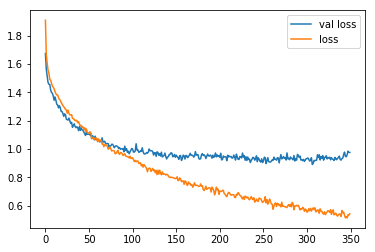

In [150]:
#define hyperparams set
best_hyperparams = {}
best_hyperparams['hidden_layer'] = best_hyper[0]
best_hyperparams['dropout'] = best_hyper[1]
best_hyperparams['epoch'] = best_hyper[2]

model = create_model(best_hyperparams)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=best_hyperparams['epoch'],verbose=1)
    
# plot loss history
hist = history.history
val_loss = hist['val_loss']
loss = hist['loss']
plt.figure()
plt.plot(val_loss)
plt.plot(loss)
plt.legend(['val loss','loss'])

In [151]:
# evaluate the model
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

762/762 [==============================] - 0s 303us/step

acc: 69.95%


## Analysis of Results
From the above loss plot, we see that training loss is decreasing. However, validation loss appears to plateau at about 200 epochs. Despite training for more epochs, the model does not show signs of overfitting yet. While the validation accuracy is about 74% at the 350th epoch, the test accuracy is approximately 70% - this may be a sign of overfitting.

## Kaggle submission

In [161]:
X_test = np.loadtxt('./data/feature_extraction_kaggle.csv',delimiter=',')
m_test = X_test.shape[0]
# zscore_test = StandardScaler()
# X_test = zscore.fit_transform(X_test) #scales each feature column
predictions = np.argmax(model.predict(X_test),axis=1)
idx = np.arange(m_test)
predictions_str = encoder.inverse_transform(predictions)

df_test = {'series_id':idx,
           'surface':predictions_str
          }
df_test = pd.DataFrame(df_test)
df_test.to_csv('./kaggle/kaggle.csv',index=False)